In [1]:
from ipynb.fs.full.Observer import *
from time import sleep

In [2]:
@dataclass
class TrackedObject:
    changeSet: dict
    
    def __repr__(self):
        changeSet = {camNum: cS for camNum, cS in self.changeSet.items() if cS is not None and cS.changeType != 'delete'}
        return f"TrackedObject({changeSet})"
    
    def __eq__(self, other):
        return \
            sum([self.changeSet[camNum] == (oCS if (oCS := other.changeSet[camNum]) is not None else None) for camNum in self.changeSet.keys()]) == len(self.changeSet)
    
    def previousVersion(self):
        return type(self)({camNum: change.lastChange if change is not None else None for camNum, change in self.changeSet.items()})

In [3]:
class DebugMachine(CaptureMachine):
    """ Camera Capture State Machine, primary loop:
                                 {on interaction detection} --> (interaction)            
                                 /                                      |
                __init__ ---> (idle)                                    V
                                  ^------- (observation) <--------- (debounce)
            
    """
    states = ["idle", "interaction", "debounce", "observation", "error"]
    mode = ["terrain", "add_unit", "move_unit"]
    observationThreshold = 3
    def __init__(self, captureConfiguration: CaptureConfiguration):
        self.cc = captureConfiguration
        self.mode = "unit"
        self.cc.capture()
        self.cc.setBase()
        self.cc.setReference()
        self.state = "idle"
        self.interactionDetected = False
        self.nextState = self.next_state()
        self.debounceCounter = 0
        self.cycleCounter = 0
        self.memory = []
        self.buildPrimeReference()
        self.lastChanges = None
        
    def __repr__(self):
        return f"CapMac -- {self.state}\nMode: {self.mode}\nID: {self.interactionDetected} | DC: {self.debounceCounter}"
    
    def interactionDetection(self):
        detections = {cam.camNum: cam.interactionDetection(cam.mostRecentFrame) for cam in cameras.values()}
        return sum(detections.values()) > 0

    def buildPrimeReference(self):
        self.cc.capture()
        self.primeReference = {camNum: cameras[camNum].mostRecentFrame for camNum in cameras}
    
    def updateReference(self):
        self.cc.setReference()
        
    def referenceFrameDeltas(self):
        return {camNum: cam.referenceFrameDelta() for camNum, cam in cameras.items()}
    
    def cycle(self):
        print(f"Starting Cycle {self.cycleCounter} -- S:{self.state}")
        self.cycleCounter += 1
        self.cc.capture()
        changes = self.referenceFrameDeltas()
        if sum([change is not None for change in changes.values()]):
            if changes == self.lastChanges:
                print(f"Stable changes. Committing {changes}!")
                try:
                    objDef = {}
                    for camNum, change in changes.items():
                        if change is not None:
                            objDef[camNum] = cameras[camNum].commitAndClassifyChange(change)
                        else:
                            objDef[camNum] = None
                    objDef = TrackedObject(objDef)
                    try:
                        existingIndex = self.memory.index(objDef.previousVersion())
                        print(f"Updating Memory {existingIndex}")
                        self.memory[existingIndex] = objDef
                    except ValueError:
                        print(f"New Memory")
                        self.memory.append(objDef)
                    self.cc.setReference()
                except:
                    raise
            else:
                print("Unstable changes")
                self.lastChanges = changes
        else:
            print("No changes")

In [4]:
cm = DebugMachine(cc)
cm.cc.setReference()

Saw interaction? False


In [9]:
if __name__ == "__main__":
    cm.cycle()
    sleep(1)
    print(cm.memory)

Starting Cycle 2 -- S:idle
Stable changes. Committing {0: (unclassified) [466.0, 907.0] by 72.0,66.0, 2: (unclassified) [702.0, 1281.0] by 60.0,45.0, 4: (unclassified) [592.0, 727.0] by 68.0,59.0}!
Adding (add) [466.0, 907.0] by 72.0,66.0
Adding (add) [702.0, 1281.0] by 60.0,45.0
Adding (add) [592.0, 727.0] by 68.0,59.0
New Memory
[TrackedObject({0: (add) [466.0, 907.0] by 72.0,66.0, 2: (add) [702.0, 1281.0] by 60.0,45.0, 4: (add) [592.0, 727.0] by 68.0,59.0})]


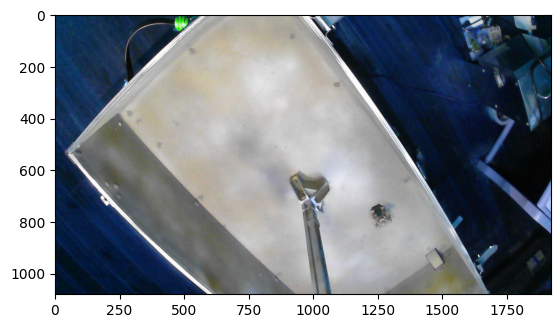

In [6]:
plt.imshow(cameras[4].mostRecentFrame)

In [7]:
plt.imshow(cm.memory[0].changeSet[0].beforeAfter())

IndexError: list index out of range

In [ ]:
cm.memory